In [1]:
%load_ext autoreload
%autoreload 2


In [96]:
import xarray as xr
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hyperopt import fmin, hp, partial, tpe, Trials
import sys
sys.path.append('../..')
from pipeline.backtest import cross_validation
import pipeline.backtest_trading as bt
from portfolio import Portfolio
from visualization.trading_stat import analyze_stat, bear_market_suite

random_state = 42


In [3]:
base_ds = xr.open_dataset('../../data/nc_2round/base.nc')
fundamental_v0_ds = xr.open_dataset('../../data/nc_2round/fundamental_v0.nc')
market_ds = xr.open_dataset('../../data/nc_2round/market_brief.nc')

ds = xr.merge([base_ds, fundamental_v0_ds, market_ds])


In [4]:
## adding intraday feature
ds['volume_0'] = ds['volume'].sum(dim='timeslot')
ds['morning_volume_ratio'] = ds['volume'].isel(timeslot=slice(2)).sum(dim='timeslot') / ds['volume_0']
ds['tail_volume_ratio'] = ds['volume'].isel(timeslot=slice(-3, -1)).sum(dim='timeslot') / ds['volume_0']
ds['daily_volume_moving_3_ratio'] = ds['volume_0'] / ds['volume_0'].rolling(day=3).mean()
ds['daily_volume_moving_5_ratio'] = ds['volume_0'] / ds['volume_0'].rolling(day=5).mean()
ds['close_moving_5_ratio'] = ds['close_0'] / ds['close_0'].rolling(day=5).mean()
ds['close_moving_10_ratio'] = ds['close_0'] / ds['close_0'].rolling(day=10).mean()
ds['close_moving_20_ratio'] = ds['close_0'] / ds['close_0'].rolling(day=20).mean()

In [5]:
class MAPortfolio:
    def __init__(self):
        pass

    def initialize(self, X, y):
        pass

    def train(self, X, y):
        pass

    def construct(self, X):
        current_day = X.day.max().item()
        X_ = X.sel(day=[current_day])
        ma_5 = X_.close_moving_5_ratio
        ma_20 = X_.close_moving_20_ratio
        y_sgn_1 = 10 > (ma_20 / ma_5)
        y_sgn_2 = (ma_20 / ma_5) > 1.02
        y_sgn = y_sgn_1 & y_sgn_2
        s = y_sgn.sum(dim='asset').item()
        # print(y_sgn)
        # if s < 1e-6:
        #    return y_sgn
        # return y_sgn / s
        return y_sgn / 54

In [6]:
ma_portfolio = MAPortfolio()
features = ['earnings', 'earnings_ttm', 'book', 'sales', 'cashflow', 'market_cap', 'volatility',
            'morning_volume_ratio', 'tail_volume_ratio', 'daily_volume_moving_3_ratio',
            'daily_volume_moving_5_ratio', 'close_moving_5_ratio', 'close_moving_10_ratio', 'close_moving_20_ratio']
stat = bt.cross_validation(ma_portfolio, features, ds, lookback_window=10, need_full_lookback=True)

  0%|          | 0/1700 [00:00<?, ?it/s]

In [72]:
class PEPortfolio(Portfolio):
    def __init__(self):
        super().__init__(1, 'pe_10_20')

    def initialize(self, X, y):
        pass

    def train(self, X, y):
        pass

    def construct(self, X):
        current_day = X.day.max().item()
        X_ = X.sel(day=[current_day])
        pe = X_.pe
        good_company = (pe > 0) & (pe < 15)
        good_trend = X_['close_moving_5_ratio'] < X_['close_moving_20_ratio']
        good = good_trend & good_company
        market_pe = pe.median().item()
        investment = np.where(good, pe**(-5), 0)
        s = max(1e-6, investment.sum())
        y = investment / s
        propose = y * min(50 / market_pe, 1)
        propose[propose < 0.01] = 0
        # print(current_day, np.where(propose > 0), propose[np.where(propose > 0)])
        return propose

  0%|          | 0/141 [00:00<?, ?it/s]

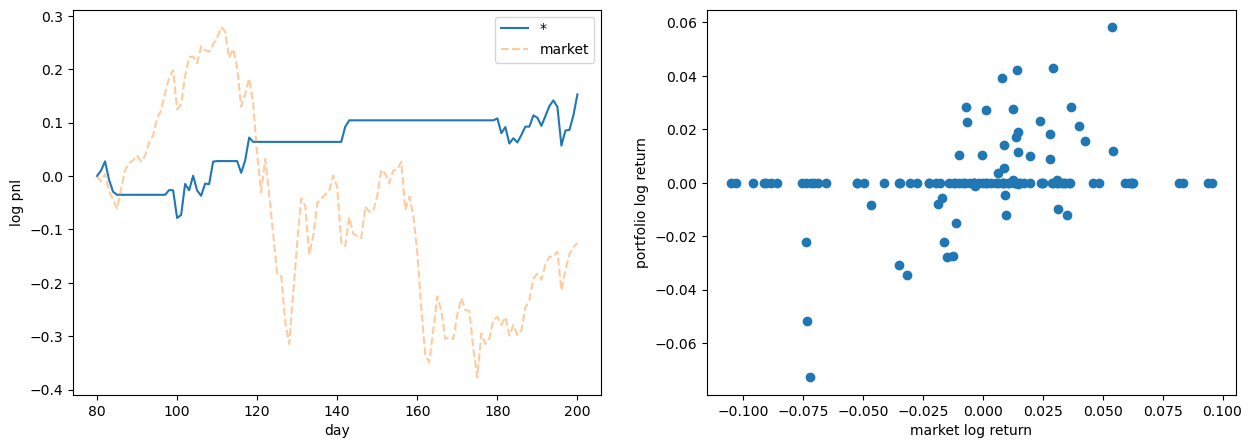

In [73]:
pe_portfolio = PEPortfolio()
stat = bt.cross_validation(pe_portfolio, ['pe', 'close_moving_5_ratio', 'close_moving_20_ratio'],
                           ds.sel(day=slice(70, 210)), lookback_window=3, need_full_lookback=True)
analyze_stat(stat)

  0%|          | 0/381 [00:00<?, ?it/s]

Summary of scores:
1. APR: 8.4360%
2. Sharpe: 0.2395
3. Maximum drawdown: 0.1868
4. Median number of traded instruments: 3.0


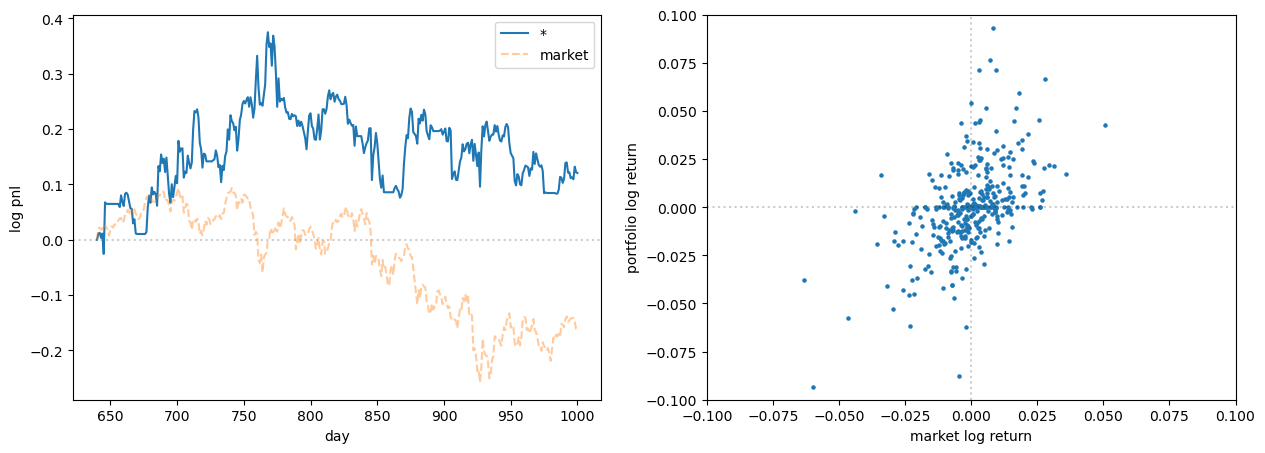

In [94]:
pe_portfolio = PEPortfolio()
stat = bt.cross_validation(pe_portfolio, ['pe', 'close_moving_5_ratio', 'close_moving_20_ratio'],
                           ds.sel(day=slice(630, 1010)), lookback_window=3, need_full_lookback=True)
analyze_stat(stat)

  0%|          | 0/291 [00:00<?, ?it/s]

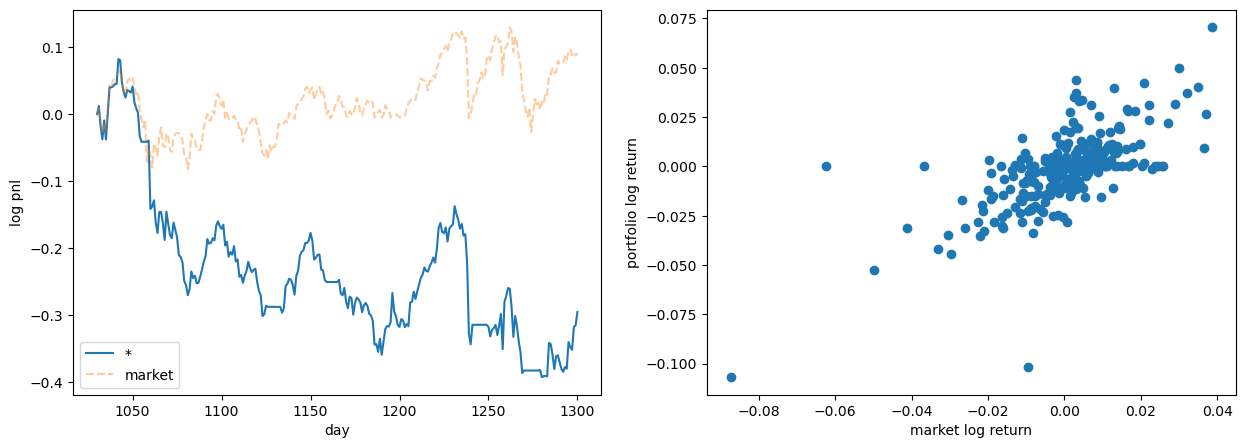

In [75]:
pe_portfolio = PEPortfolio()
stat = bt.cross_validation(pe_portfolio, ['pe', 'close_moving_5_ratio', 'close_moving_20_ratio'],
                           ds.sel(day=slice(1020, 1310)), lookback_window=3, need_full_lookback=True)
analyze_stat(stat)

Summary of scores:
1. APR: -27.5484%
2. Sharpe: -0.9308
3. Maximum drawdown: 0.1506
4. Median number of traded instruments: 4.0


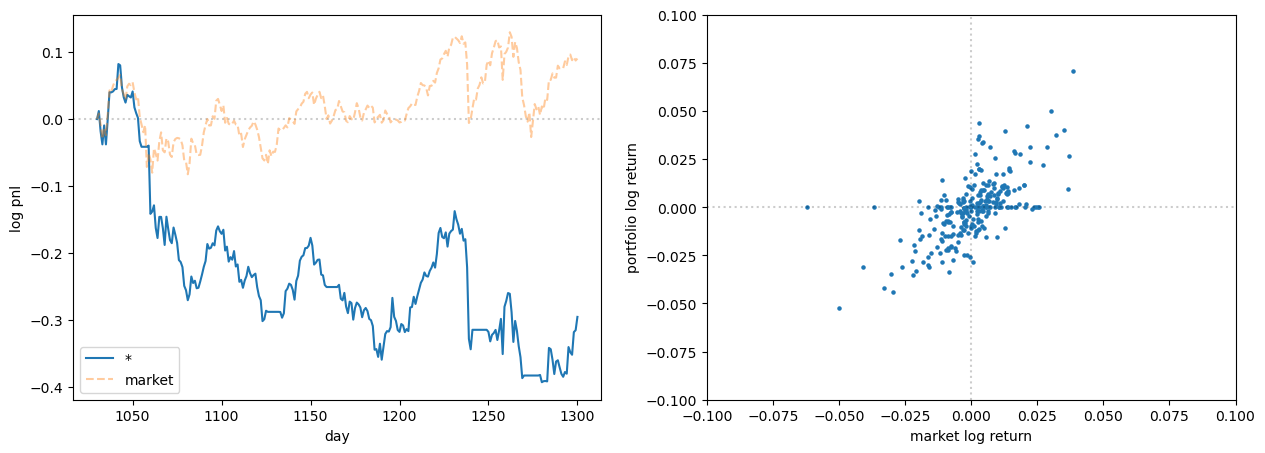

In [93]:
analyze_stat(stat)

In [86]:
rr = stat.holding_return.sel(asset=3).cumsum()
running_max = np.maximum.accumulate(rr.to_numpy())
np.max(running_max - rr)

<xarray.DataArray 'holding_return' ()>
array(0.02000852)
Coordinates:
    asset    int32 3

In [90]:
(stat.holding_return != 0).sum(dim='asset').median()

<xarray.DataArray 'holding_return' ()>
array(4.)

In [46]:
np.unique(np.where(ds.sel(day=slice(120, 170))['pe'] < 15)[1])

array([ 3,  4,  6, 30, 33, 46, 48, 53])

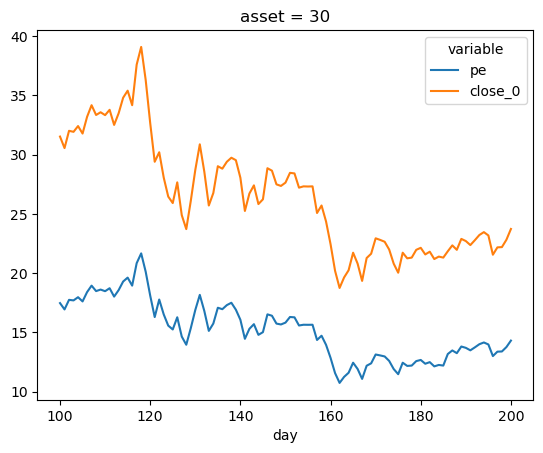

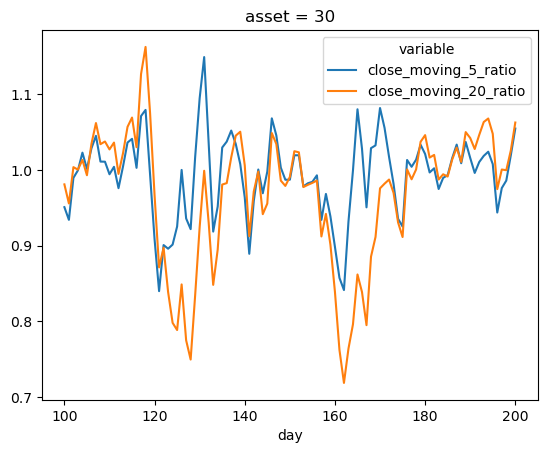

In [70]:
ds[['pe', 'close_0']].sel(day=slice(100, 200), asset=30).to_array().plot.line(x='day')
plt.figure()
ds[['close_moving_5_ratio', 'close_moving_20_ratio']].sel(day=slice(100, 200), asset=30).to_array().plot.line(x='day')

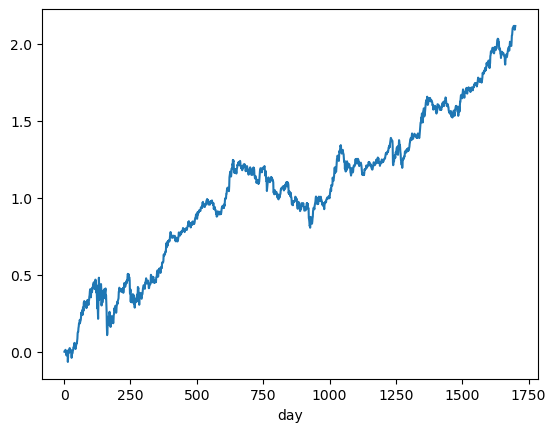

In [38]:
# PE>0
simple_return = (stat.odd_holding_return - stat.odd_open_fee.shift(day=1) - stat.odd_close_fee).fillna(0).sum(dim='asset')
simple_return = (stat.even_holding_return - stat.even_open_fee.shift(day=1) - stat.even_close_fee).fillna(0).sum(dim='asset')
(np.log(simple_return + 1).cumsum()).plot(x='day')

Now testing period (80, 200):


  0%|          | 0/121 [00:00<?, ?it/s]

Summary of scores:
1. APR: 26.4364%
2. Sharpe: 1.1097
3. Maximum drawdown: 0.1309
4. Median number of traded instruments: 0.0
Now testing period (640, 1000):


  0%|          | 0/361 [00:00<?, ?it/s]

Summary of scores:
1. APR: 7.7236%
2. Sharpe: 0.2193
3. Maximum drawdown: 0.1868
4. Median number of traded instruments: 3.0
Now testing period (1030, 1300):


  0%|          | 0/271 [00:00<?, ?it/s]

Summary of scores:
1. APR: -29.0976%
2. Sharpe: -0.9853
3. Maximum drawdown: 0.1506
4. Median number of traded instruments: 4.0


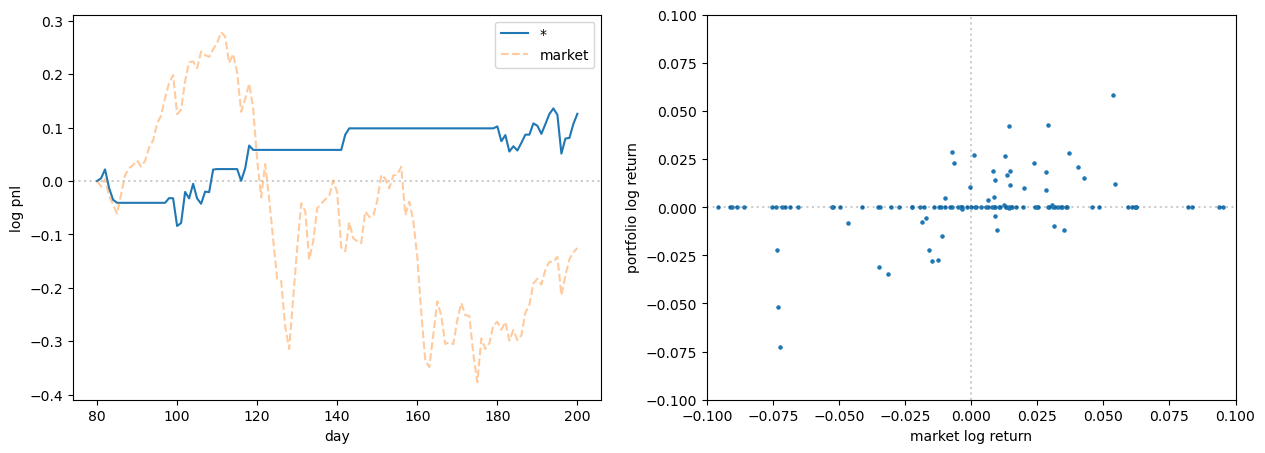

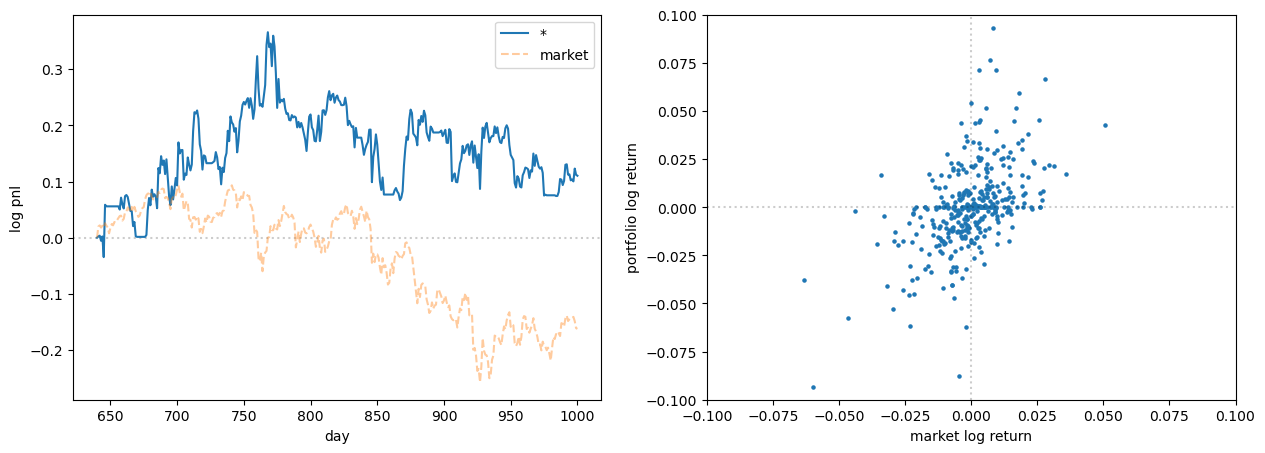

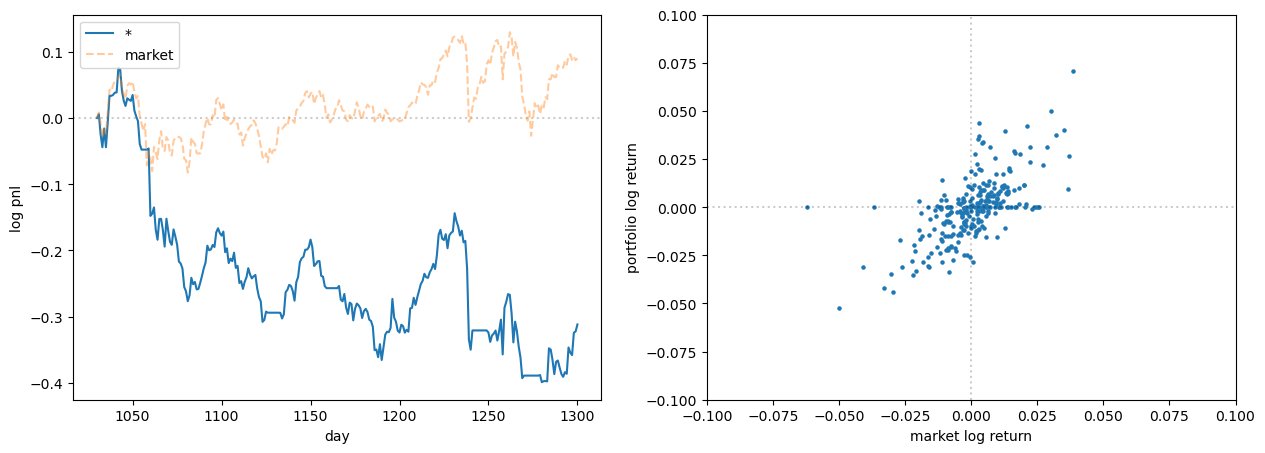

In [98]:
pe_p = PEPortfolio()
bear_market_suite(pe_p, ['pe', 'close_moving_5_ratio', 'close_moving_20_ratio'],
                           ds, lookback_window=3, need_full_lookback=True)

## Market index!

In [10]:
market_return = ds['return_0'].mean(dim='asset')
market_log_return = np.log(market_return + 1)

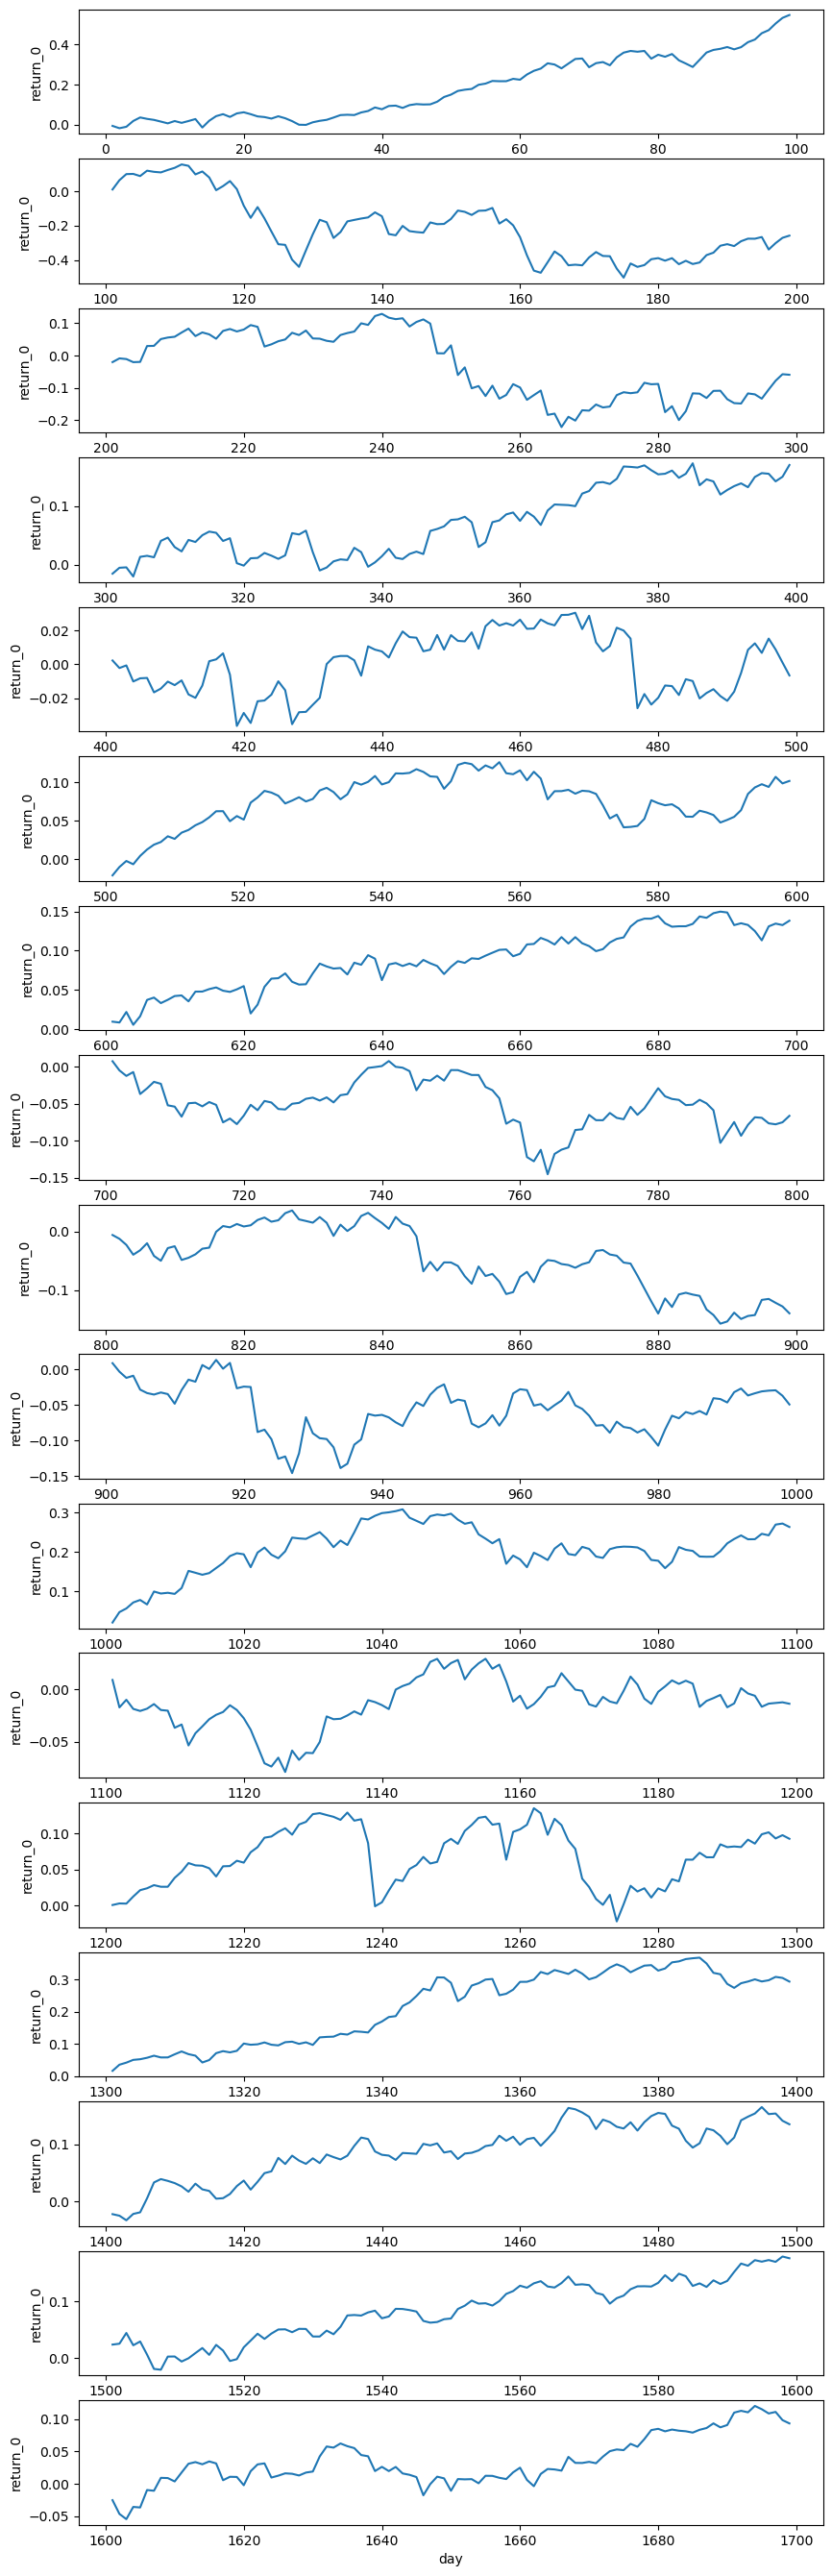

In [11]:
fig, axs = plt.subplots(17, 1, figsize=(10, 34))
for i, ax in enumerate(axs):
    day_range = range(i*100+1, (i+1)*100)
    market_log_return.sel(day=day_range).cumsum().plot(ax=ax)

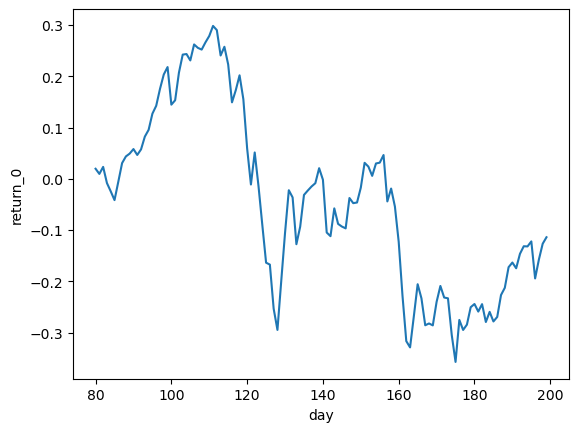

In [12]:
market_log_return.sel(day=range(80, 200)).cumsum().plot()

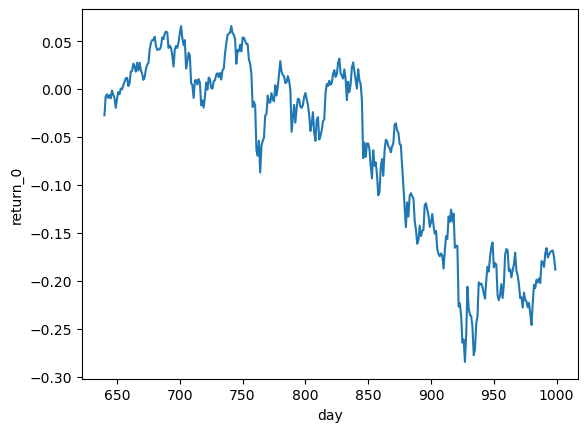

In [13]:
market_log_return.sel(day=range(640, 1000)).cumsum().plot()

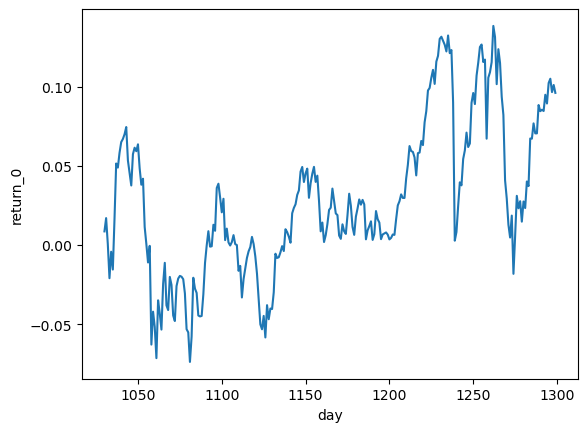

In [14]:
market_log_return.sel(day=range(1030, 1300)).cumsum().plot()

## roadmap
- all features zoom in bear time
- market investment pnl (odd/even/all)
- market return vs strategy return scatterplot(odd/even/all)
- misc performance: overall profit, sharpe ratio, max drawback, average instrument traded

### beta_stat

In [15]:
market_return = ds['return_0'].mean(dim='asset')

In [29]:
hh = ds.sel(day=slice(100, 120), asset=0)['close_0'].copy()

In [34]:
xr.concat([xr.DataArray([0.1], coords={'day': [99]}), hh], dim='day')

<xarray.DataArray (day: 22)>
array([ 0.1   , 35.3944, 35.9042, 37.47  , 38.5017, 37.3608, 40.1646,
       41.7426, 41.512 , 40.1768, 40.3953, 40.0068, 40.0068, 41.4877,
       38.4532, 38.2711, 36.2198, 32.7969, 34.1442, 35.1881, 33.1003,
       29.7867])
Coordinates:
    asset    int32 0
  * day      (day) int64 99 100 101 102 103 104 105 ... 115 116 117 118 119 120